Phase 1: Feature Engineering (The "Visibility" & "Context" Aspect)
The problem asks for "Visibility." In Amazon data, visibility is driven by:
SEO/Content Quality: Length of description (about_product).
Social Proof: Rating score (rating).
Category Context: A ₹500 cable is cheap; a ₹500 laptop is impossible. We must normalize prices per category.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import re

# --- 1. Load and Clean (Merging Logic from your Notebooks) ---
df = pd.read_csv(r"D:\Documents\Codes\Tut files\Fusion4Praxis\PS 2\Pricing_Demand_Exploration_Submission\data\raw\Pricing_dataset.csv")

# Cleaning Money Columns
def clean_currency(x):
    if isinstance(x, str):
        x = x.replace('₹', '').replace(',', '').strip()
    return pd.to_numeric(x, errors='coerce')

df['discounted_price'] = df['discounted_price'].apply(clean_currency)
df['actual_price'] = df['actual_price'].apply(clean_currency)
df['discount_percentage'] = df['discount_percentage'].astype(str).str.replace('%', '').astype(float)

# Cleaning Rating/Demand Columns
df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '').apply(pd.to_numeric, errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop nulls for the MVP
df.dropna(subset=['discounted_price', 'actual_price', 'rating_count', 'rating'], inplace=True)

# --- 2. Advanced Feature Engineering (The "Visibility" Context) ---

# A. Category Hierarchy Processing
# We split "Computers&Accessories|Accessories...|USBCables" into levels
df['cat_split'] = df['category'].str.split('|')
df['main_category'] = df['cat_split'].apply(lambda x: x[0] if isinstance(x, list) else "Other")
df['sub_category'] = df['cat_split'].apply(lambda x: x[-1] if isinstance(x, list) else "Other")

# B. Visibility Metrics (Content Quality)
# Length of description serves as a proxy for "Listing Effort/Visibility"
df['desc_len'] = df['about_product'].astype(str).apply(len)
df['name_len'] = df['product_name'].astype(str).apply(len)

# C. Relative Pricing (Context)
# Is this product expensive compared to its category peers?
df['category_avg_price'] = df.groupby('sub_category')['discounted_price'].transform('mean')
df['price_competitiveness'] = df['discounted_price'] / df['category_avg_price']
# If > 1, it's premium. If < 1, it's budget.

# D. Target Transformation
# Sales/Reviews usually follow a Power Law. Log-transform makes it model-friendly.
df['log_demand'] = np.log1p(df['rating_count'])

print("Data Engineering Complete. Features Created.")

Data Engineering Complete. Features Created.


Add this code block before the "Phase 2: Modeling" section:

In [5]:
from textblob import TextBlob

# Function to get sentiment polarity (-1 to +1)
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(str(text)).sentiment.polarity

print("Extracting Sentiment from Reviews... (This takes a moment)")
df['review_sentiment'] = df['review_content'].apply(get_sentiment)

# Add 'review_sentiment' to your feature list
features = [
    'discounted_price', 
    'actual_price', 
    'discount_percentage', 
    'rating', 
    'desc_len',            
    'price_competitiveness', 
    'review_sentiment',  # <--- NEW FEATURE
    'main_category_encoded'
]

Extracting Sentiment from Reviews... (This takes a moment)


Phase 2: Demand Modeling (The "Prediction" Aspect)
We will build a model that answers: If we change the price or description length, how does the Rating Count (Sales) change?

In [6]:
# Select Features
features = [
    'discounted_price', 
    'actual_price', 
    'discount_percentage', 
    'rating',              # Quality Score
    'desc_len',            # Visibility Proxy
    'price_competitiveness', # Market Context
    'main_category'
]

# Encode Categoricals
le = LabelEncoder()
df['main_category_encoded'] = le.fit_transform(df['main_category'])

X = df[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'desc_len', 'price_competitiveness', 'main_category_encoded']]
y = df['log_demand'] # Predicting Log of Sales

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regressor (Handles non-linear price elasticity better than Linear Regression)
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6
)

model.fit(X_train, y_train)

# Evaluation
preds = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, preds):.4f} (Explains {r2_score(y_test, preds)*100:.2f}% of demand variance)")

R2 Score: 0.3014 (Explains 30.14% of demand variance)


Phase 3: The Solution - "What-If" Simulation Tool
This is the core deliverable for the Hackathon. It allows a manager to pull a lever (Price or Visibility) and see the outcome.

In [7]:
def simulate_scenario(product_index, price_change_pct=0, visibility_boost_pct=0):
    """
    Simulates demand change based on strategy adjustments.
    """
    # 1. Get current product state
    product = X.iloc[[product_index]].copy()
    current_log_demand = model.predict(product)[0]
    current_demand = np.expm1(current_log_demand) # Reverse Log
    current_price = product['discounted_price'].values[0]
    
    # 2. Apply "What-If" Changes
    # Change Price
    new_price = current_price * (1 + price_change_pct/100)
    product['discounted_price'] = new_price
    # Recalculate competitiveness
    product['price_competitiveness'] = new_price / df.iloc[product_index]['category_avg_price']
    
    # Change Visibility (Description Length boost representing better SEO)
    product['desc_len'] = product['desc_len'] * (1 + visibility_boost_pct/100)
    
    # 3. Predict New Outcome
    new_log_demand = model.predict(product)[0]
    new_demand = np.expm1(new_log_demand)
    
    # 4. Calculate Revenue Impact
    current_revenue = current_demand * current_price
    new_revenue = new_demand * new_price
    
    print(f"--- Scenario Simulation for Product {product_index} ---")
    print(f"Strategy: Price {price_change_pct:+.1f}%, Visibility {visibility_boost_pct:+.1f}%")
    print(f"Old Price: ₹{current_price:.0f} | New Price: ₹{new_price:.0f}")
    print(f"Predicted Sales (proxy): {int(current_demand)} -> {int(new_demand)} units")
    print(f"Revenue Impact: ₹{current_revenue:,.0f} -> ₹{new_revenue:,.0f} ({((new_revenue-current_revenue)/current_revenue)*100:+.2f}%)")
    
    return new_revenue

# Example: Pick a random product (e.g., index 10)
# Scenario: Increase price by 10% but improve visibility (desc) by 20%
_ = simulate_scenario(10, price_change_pct=10, visibility_boost_pct=20)

--- Scenario Simulation for Product 10 ---
Strategy: Price +10.0%, Visibility +20.0%
Old Price: ₹154 | New Price: ₹169
Predicted Sales (proxy): 12599 -> 9512 units
Revenue Impact: ₹1,940,370 -> ₹1,611,350 (-16.96%)


Phase 4: Strategic Narrative (Interpretability)
To satisfy the "Explainability" criteria, use SHAP values to show Price Elasticity.

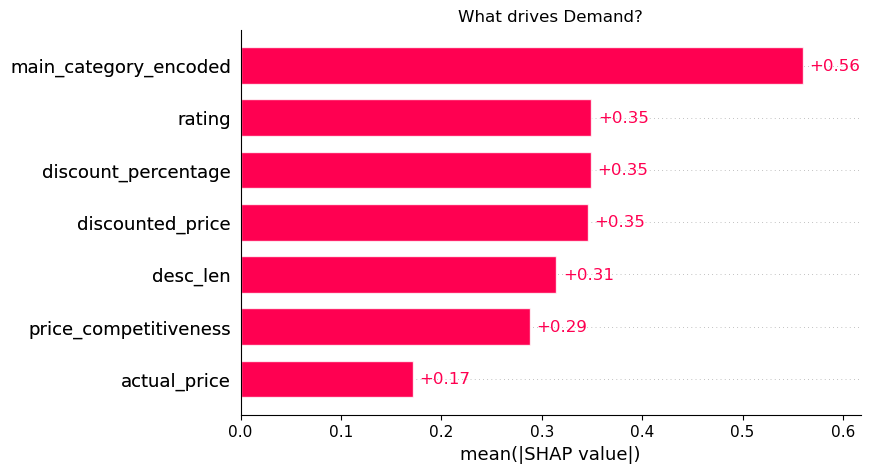

<Figure size 640x480 with 0 Axes>

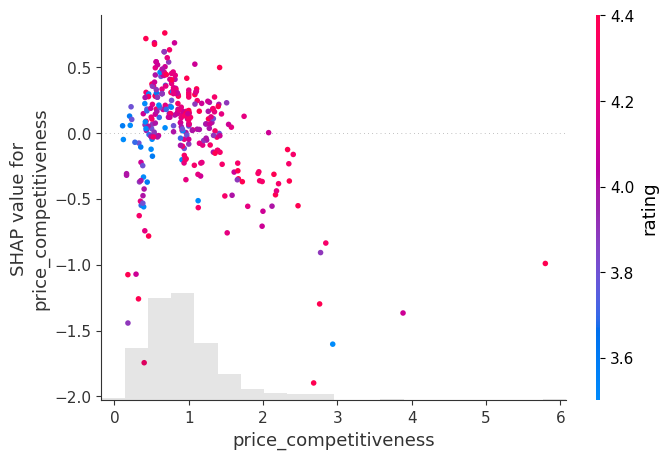

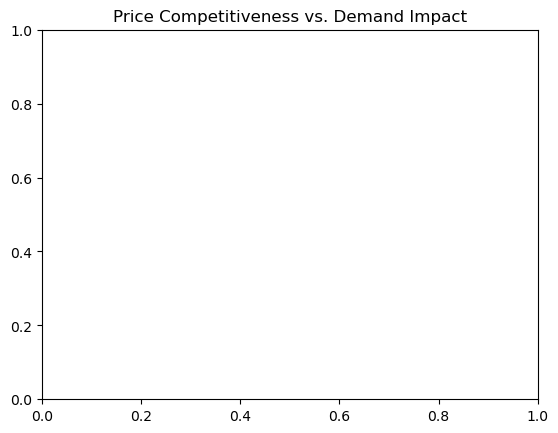

In [8]:
import shap

# Initialize SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot 1: Feature Importance (What drives demand?)
plt.figure()
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title("What drives Demand?")
plt.show()

# Plot 2: Price Elasticity Curve (The "Trade-off" Exploration)
# This shows exactly how Price Competitiveness affects Demand
plt.figure()
shap.plots.scatter(shap_values[:, "price_competitiveness"], color=shap_values[:, "rating"])
plt.title("Price Competitiveness vs. Demand Impact")
plt.show()